In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from envs.env import *
import pandas as pd
from config import settings
import pickle
from constants import MAB_FEATURE_NAMES

RESTART_data = True
RESTART = True 

## Open Data

In [3]:
catalog_df = pd.read_parquet("data/whatson_catalog_df.parquet")
historical_data_df = pd.read_pickle("data/historical_data_df.pkl")
with open(settings.aud_model_dir/"rf_model.pkl", "rb") as f:    # load frozen viewership model
    audience_model = pickle.load(f)

In [4]:
historical_data_df['catalog_id'] = historical_data_df['catalog_id'].astype('Int64')

In [5]:
historical_data_df['catalog_id'].value_counts()

catalog_id
-1        18
796648     6
916373     4
881770     4
763285     3
          ..
935160     1
395993     1
868522     1
15120      1
43799      1
Name: count, Length: 1337, dtype: Int64

In [6]:
id = 762504
historical_data_df[historical_data_df['catalog_id'] == id]

,title,date,content_class_key,channel,duration_min,hour,day,weekday,is_weekend,month,rt_m,tmdb_id,season,processed_title,missing_tmdb_id,catalog_id
40406,Nope,2024-07-17,71,RTS 1,123.116667,22,17,2,False,7,16.8,762504.0,summer,Nope,False,762504
41286,NOPE,2024-07-21,AAD,France 2,126.583333,22,21,6,True,7,8.0,762504.0,summer,Nope,False,762504
48180,NOPE,2024-08-18,AAD,France 2,27.016667,25,18,6,True,8,2.2,762504.0,summer,Nope,False,762504


## Prepare Environment

In [7]:
env = TVProgrammingEnvironment(movie_catalog=catalog_df,
                         historical_df= historical_data_df,
                         audience_model=audience_model,
                         reward_weights= None)

Setting up CompetitorDataManager...
Setting up Scalers...
Setting up RewardCalculator...


In [8]:
temp = env.competitor_manager.competitor_historical_data
temp[temp['catalog_id'] == 762504]
movie_competitor_context = env.competitor_manager.get_movie_competitor_context(762504, reference_date='2024-07-17')
movie_competitor_context.competitor_showings

[{'channel': 'France 2', 'air_date': '2024-07-21', 'air_hour': 22}]

In [9]:
from IL_training import *

hist_data_processor = HistoricalDataProcessor(environment=env)

## Prepare Traing Data

competitive_showings = [771077, 398920, 398920, 770554, 594691, 455446, 658905, 745589, 838916, 546554, 925102, 880728, 1149095, 762504, 446354, 768127]

In [10]:
env.movie_catalog

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown,info_score
catalog_id,,,,,,,,,,,,,,,,,,,,,
220,A l'est d'eden,"James Dean, Julie Harris, Raymond Massey, Rich...",False,0.0,A l'est d'éden,1.0,71,1995-05-26,1998-12-24,1998-12-24,...,220.0,1.0,0,7.600,True,False,True,70,0,40
12155,Alice au pays des merveilles,None,False,2.0,Alice au pays des merveilles,0.0,71,None,None,None,...,12155.0,2.0,0,6.635,True,False,True,15,0,33
XF_000_0,Rocket a monte carlo,None,False,3.0,Amicalement votre,0.0,71,None,None,None,...,NaN,3.0,0,0.000,True,True,True,125,0,32
11806,Beethoven,"Charles Grodin, Bonnie Hunt, Dean Jones, Tom N...",False,3.0,Beethoven,0.0,71,None,None,None,...,11806.0,3.0,0,5.830,True,False,True,33,0,37
279332,Bonne fete maman,None,False,2.0,Bonne fête maman,0.0,71,None,None,None,...,279332.0,2.0,0,5.900,True,False,True,11,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XF_000_460,Séparation dangereuse,"Ulrich Tukur, Annett Renneberg, Peter Fitz, Su...",False,1.0,Téléfilm,1.0,71,1999-10-08,2002-03-23,2002-03-23,...,NaN,2.0,0,0.000,True,True,True,125,0,39
XF_000_461,La vie d'un basketteur hors du commun,"Dwayne Adway, John Terry, Dee Wallace-Stone",False,1.0,Téléfilm,1.0,71,2002-03-17,2002-03-17,None,...,NaN,2.0,0,0.000,True,True,True,125,0,38
733369,De gré ou de force,"Laurent Arnal, Marie Desgranges, Philippe Faur...",False,1.0,Téléfilm,1.0,71,1999-03-19,2001-12-08,2001-12-08,...,733369.0,2.0,0,5.500,True,False,True,26,0,39


In [11]:
if RESTART_data:
    training_data, all_rewards, movies_not_found = hist_data_processor.prepare_training_data(channel_name='RTS 1')

Processing historical programming data...
Found 973 programming decisions for RTS 1


Processing rows: 100%|██████████| 973/973 [03:49<00:00,  4.24it/s]


Created 973 positive samples


In [12]:
a = hist_data_processor.env.movie_catalog.copy()
a[a['times_shown'] > 0]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown,info_score
catalog_id,,,,,,,,,,,,,,,,,,,,,
744941.0,Cher Noël,,False,NaN,NaN,NaN,72,NaN,NaN,NaN,...,744941.0,NaN,NaN,6.500,True,False,True,4,1,NaN
36670.0,James Bond: Jamais plus jamais,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,36670.0,NaN,NaN,6.051,True,False,True,41,1,NaN
746333.0,Super-héros malgré lui,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,746333.0,NaN,NaN,6.400,True,False,True,3,1,NaN
262391.0,Qu'est-ce qu'on a fait au Bon Dieu ?,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,262391.0,NaN,NaN,6.665,True,False,True,11,1,NaN
459992.0,Séduis-moi si tu peux,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,459992.0,NaN,NaN,6.726,True,False,True,6,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95363.0,LE MIRACLE DES LOUPS,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,95363.0,NaN,NaN,5.800,True,False,True,63,1,NaN
1025208.0,Rencard avec le diable,,False,NaN,NaN,NaN,72,NaN,NaN,NaN,...,1025208.0,NaN,NaN,6.500,True,False,True,2,1,NaN
356326.0,What We Become,,False,NaN,NaN,NaN,71,NaN,NaN,NaN,...,356326.0,NaN,NaN,5.500,True,False,True,9,1,NaN


In [13]:
import pickle
from pathlib import Path

TRAINING_PATH = Path("data/IL_data/training_data.pkl")
REWARDS_PATH = Path("data/IL_data/all_rewards.pkl")
MISSING_PATH = Path("data/IL_data/movies_not_found.pkl")

if RESTART_data:
    TRAINING_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(TRAINING_PATH, "wb") as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(REWARDS_PATH, "wb") as f:
        pickle.dump(all_rewards, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(MISSING_PATH, "wb") as f:
        pickle.dump(movies_not_found, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(TRAINING_PATH, "rb") as f:
        training_data = pickle.load(f)

    with open(REWARDS_PATH, "rb") as f:
            all_rewards = pickle.load(f)

    with open(MISSING_PATH, "rb") as f:
            movies_not_found = pickle.load(f)


In [14]:
hist_data_processor.env.movie_catalog.loc['1000094']

title                                                             Le clan
actors                  Eric Fraticelli, Philippe Corti, Jean-François...
adult                                                               False
available_num_diff                                                    2.0
collection                                                           Film
consumed_num_diff                                                     0.0
content_class_key                                                      71
date_diff_1                                                          None
date_last_diff                                                       None
date_rediff_1                                                        None
date_rediff_2                                                        None
date_rediff_3                                                        None
date_rediff_4                                                        None
department                            

## Visualize Reward Distributions

In [15]:
np.median(training_data['reward_targets'])

0.0

In [16]:
reward_audience = [d['audience'] for d in all_rewards]
reward_competition = [d['competition'] for d in all_rewards]
reward_diversity = [d['diversity'] for d in all_rewards]
reward_novelty = [d['novelty'] for d in all_rewards]
reward_rights = [d['rights'] for d in all_rewards]

In [17]:
def show_specs(signal):
    minimum = np.min(signal)
    maximum = np.max(signal)
    median  = np.median(signal)
    mean    = np.mean(signal)
    q1      = np.percentile(signal, 25)
    q3      = np.percentile(signal, 75)
    iqr     = q3 - q1

    print(f"Min:    {minimum}")
    print(f"Q1:     {q1}")
    print(f"Median: {median}")
    print(f"Q3:     {q3}")
    print(f"Max:    {maximum}")
    print(f"IQR:    {iqr}")
    print(f"Mean:   {mean}")

In [18]:
print('------Total Rewards----------')
show_specs(training_data['reward_targets'])

------Total Rewards----------
Min:    0.0
Q1:     0.0
Median: 0.0
Q3:     0.0
Max:    1.0
IQR:    0.0
Mean:   0.16666666666666666


In [19]:
print('------Audience----------')
show_specs(reward_audience)
print('\n------Competition----------')
#show_specs([x for x in reward_competition if x > 0])
show_specs(reward_competition)
print('\n------Diversity----------')
show_specs(reward_diversity)
print('\n------Novelty----------')
show_specs(reward_novelty)
print('\n------Rights----------')
show_specs(reward_rights)

------Audience----------
Min:    0.03003003003003003
Q1:     0.31431431431431434
Median: 0.5965965965965966
Q3:     0.8023023023023024
Max:    1.0
IQR:    0.48798798798798804
Mean:   0.5668875418610971

------Competition----------
Min:    0.0
Q1:     0.0
Median: 0.0
Q3:     0.0
Max:    0.8032653298563167
IQR:    0.0
Mean:   0.002782051293838017

------Diversity----------
Min:    0.3
Q1:     0.6976603251380701
Median: 0.7952771544888559
Q3:     0.8635459946814859
Max:    1.0
IQR:    0.16588566954341577
Mean:   0.7769095247087675

------Novelty----------
Min:    1.0
Q1:     1.0
Median: 1.0
Q3:     1.0
Max:    1.0
IQR:    0.0
Mean:   1.0

------Rights----------
Min:    0.0
Q1:     0.0
Median: 0.0
Q3:     0.1
Max:    1.0
IQR:    0.1
Mean:   0.1252655018842069


## Training

In [20]:
import torch

context_np = training_data['context_features']  # numpy array
movie_np = training_data['movie_features']      # numpy array

# Convert to tensors
context_tensor = torch.from_numpy(context_np)
movie_tensor = torch.from_numpy(movie_np)

# Check for NaNs
print("Context NaNs:", torch.isnan(context_tensor).any().item())
print("Movie NaNs:", torch.isnan(movie_tensor).any().item())


Context NaNs: False
Movie NaNs: False


In [21]:
if RESTART:
    # Initialize trainer
    trainer = NetworkTrainer()
    # Train Curator Network
    curator_model = trainer.train_curator_network(
        training_data=training_data,
        epochs=1000,
        batch_size=256,
        learning_rate=0.001
    )

Training Curator Network...


Epoch 0: Loss=0.4789
Epoch 10: Loss=0.0201
Epoch 20: Loss=0.0161
Epoch 30: Loss=0.0126
Epoch 40: Loss=0.0119
Epoch 50: Loss=0.0109
Epoch 60: Loss=0.0100
Epoch 70: Loss=0.0093
Epoch 80: Loss=0.0054
Epoch 90: Loss=0.0069
Epoch 100: Loss=0.0082
Epoch 110: Loss=0.0034
Epoch 120: Loss=0.0039
Epoch 130: Loss=0.0029
Epoch 140: Loss=0.0022
Epoch 150: Loss=0.0026
Epoch 160: Loss=0.0017
Epoch 170: Loss=0.0019
Epoch 180: Loss=0.0020
Epoch 190: Loss=0.0030
Epoch 200: Loss=0.0018
Epoch 210: Loss=0.0009
Epoch 220: Loss=0.0014
Epoch 230: Loss=0.0015
Epoch 240: Loss=0.0014
Epoch 250: Loss=0.0012
Epoch 260: Loss=0.0015
Epoch 270: Loss=0.0010
Epoch 280: Loss=0.0010
Epoch 290: Loss=0.0008
Epoch 300: Loss=0.0010
Epoch 310: Loss=0.0015
Epoch 320: Loss=0.0014
Epoch 330: Loss=0.0008
Epoch 340: Loss=0.0009
Epoch 350: Loss=0.0020
Epoch 360: Loss=0.0013
Epoch 370: Loss=0.0013
Epoch 380: Loss=0.0010
Epoch 390: Loss=0.0011
Epoch 400: Loss=0.0012
Epoch 410: Loss=0.0016
Epoch 420: Loss=0.0013
Epoch 430: Loss=0.0019

In [22]:
if RESTART:
    # Train Reward Model
    reward_model = trainer.train_reward_model(
        training_data=training_data,
        epochs=1000,
        batch_size=256,
        learning_rate=0.001
    )

Training Reward Model...
Epoch 0: Loss=0.1693
Epoch 10: Loss=0.0073
Epoch 20: Loss=0.0053
Epoch 30: Loss=0.0048
Epoch 40: Loss=0.0040
Epoch 50: Loss=0.0030
Epoch 60: Loss=0.0033
Epoch 70: Loss=0.0031
Epoch 80: Loss=0.0030
Epoch 90: Loss=0.0028
Epoch 100: Loss=0.0027
Epoch 110: Loss=0.0025
Epoch 120: Loss=0.0023
Epoch 130: Loss=0.0023
Epoch 140: Loss=0.0024
Epoch 150: Loss=0.0021
Epoch 160: Loss=0.0020
Epoch 170: Loss=0.0020
Epoch 180: Loss=0.0022
Epoch 190: Loss=0.0018
Epoch 200: Loss=0.0021
Epoch 210: Loss=0.0017
Epoch 220: Loss=0.0019
Epoch 230: Loss=0.0020
Epoch 240: Loss=0.0023
Epoch 250: Loss=0.0020
Epoch 260: Loss=0.0023
Epoch 270: Loss=0.0021
Epoch 280: Loss=0.0021
Epoch 290: Loss=0.0020
Epoch 300: Loss=0.0017
Epoch 310: Loss=0.0021
Epoch 320: Loss=0.0022
Epoch 330: Loss=0.0024
Epoch 340: Loss=0.0022
Epoch 350: Loss=0.0020
Epoch 360: Loss=0.0025
Epoch 370: Loss=0.0022
Epoch 380: Loss=0.0021
Epoch 390: Loss=0.0020
Epoch 400: Loss=0.0020
Epoch 410: Loss=0.0022
Epoch 420: Loss=0.00

## Save models

In [23]:

context_features = training_data['context_features']
movie_features = np.squeeze(training_data['movie_features'])
context_dim = context_features.shape[1]
movie_dim = movie_features.shape[1]

In [24]:
movie_features.shape

(5838, 24)

In [25]:
if RESTART:
    # Save models
    torch.save(curator_model.state_dict(), 'models/curator_model.pth')
    torch.save(reward_model.state_dict(), 'models/reward_model.pth')

else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Initialize model
    curator_model = CuratorNetwork(context_dim, movie_dim).to(device)
    curator_model.load_state_dict(torch.load('models/curator_model.pth'))

In [26]:
print(context_dim)
print(movie_dim)

16
24


## Prepare training Data for TS

In [27]:
aud_reward_features = np.array(reward_audience).reshape(-1,1)
comp_reward_features = np.array(reward_competition).reshape(-1,1)
div_reward_features = np.array(reward_diversity).reshape(-1,1)
nov_reward_features = np.array(reward_novelty).reshape(-1,1)
rights_reward_features = np.array(reward_rights).reshape(-1,1)

In [28]:
#X_hist = np.concatenate((context_features, movie_features, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)
interaction_features = []
for i in range(len(context_features)):
    if i == 4:
        interaction_feature, interaction_feature_names = env.build_context_movie_interactions(context_features[i], movie_features[i])
    else:
        interaction_feature, _ = env.build_context_movie_interactions(context_features[i], movie_features[i])
    interaction_features.append(interaction_feature)
interaction_features = np.array(interaction_features)


print(interaction_features.shape)


    

AssertionError: 

In [ ]:
X_hist = np.concatenate((interaction_features, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)
R_hist = training_data['curator_targets'] # Use pseudo-rewards to nudge the Bayesain model in a desired direction
print(X_hist.shape)
print(R_hist.shape)

(973, 373)
(973,)


## Seeding

In [ ]:
np.random.seed(42) 

In [ ]:
from thompson import ThompsonSampler

ts = ThompsonSampler(dim=X_hist.shape[1], lam=1.0, sigma=1.0, seed = 42)
ts.warm_start(X_hist, R_hist)


## Show weight distributions

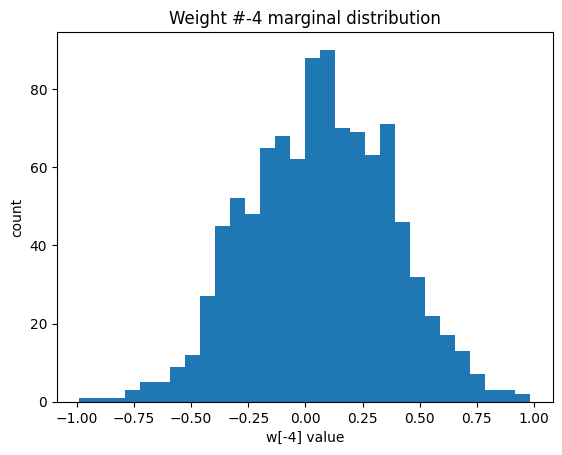

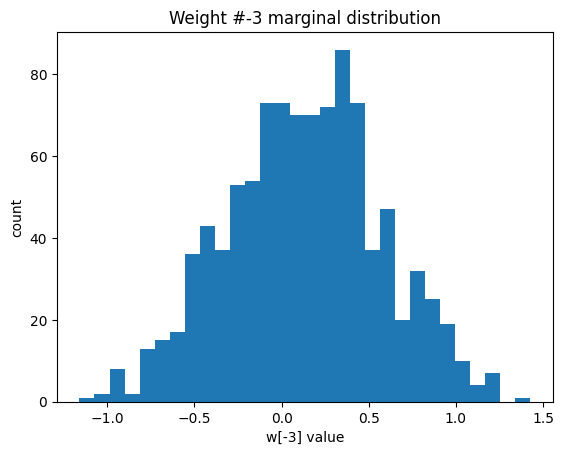

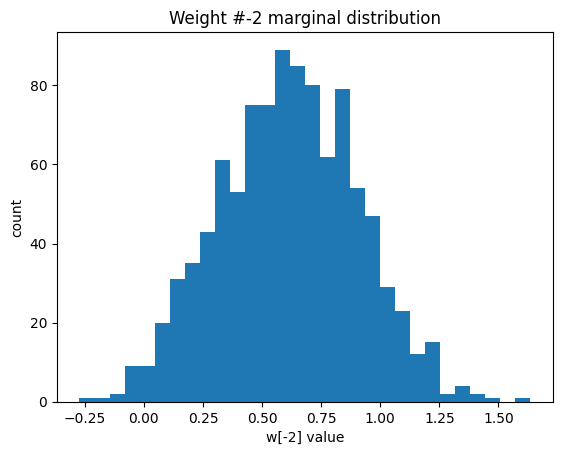

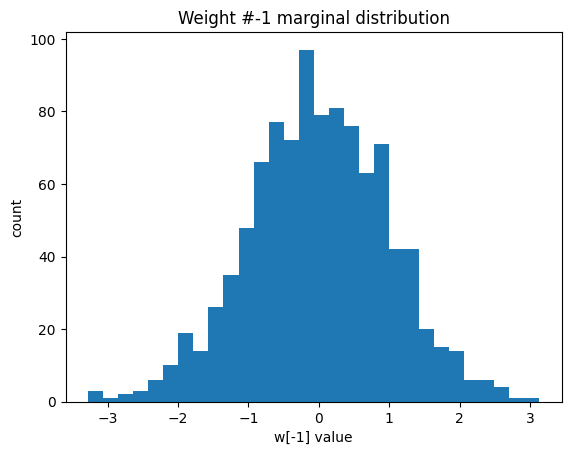

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ————————————————————————————————
# 1) Draw many posterior samples
# ————————————————————————————————
# Assume `ts` is your ThompsonSampler instance
# and ts.sample_weights() returns (w_sample, mu, cov)
num_samples = 1000
all_w = np.vstack([
    ts.sample_weights()
    for _ in range(num_samples)
])  # shape = (num_samples, d)

# ————————————————————————————————
# 2) Plot marginal histograms for each weight
# ————————————————————————————————
for i in range(-4, 0):
    plt.figure()
    plt.hist(all_w[:, i], bins=30)
    plt.title(f"Weight #{i} marginal distribution")
    plt.xlabel(f"w[{i}] value")
    plt.ylabel("count")
    plt.show()


In [ ]:
MAB_FEATURE_NAMES[-4:]

['reward_competition', 'reward_diversity', 'reward_novelty', 'reward_rights']

## Test recommendations

In [ ]:
date = '2025-08-04'
air_date = utils.date_formatting.to_datetime_format(date)
hour = 21
context = env.create_context_from_date(date, hour)
print(context)

Context(hour=21, day_of_week=0, month=8, season=<Season.SUMMER: 'summer'>)


In [ ]:
env.competitor_manager.update_competition_historical_data() # scrape future shwoings and add to historical data

[datetime.date(2025, 8, 9), datetime.date(2025, 8, 16), datetime.date(2025, 8, 23)]


Weeks for TF1: 100%|██████████| 3/3 [00:27<00:00,  9.25s/it]


Failed to scrape TF1: 404 Client Error: Not Found for url: https://tf1pro.com/grilles-xml/16/2025-08-23


Weeks for M6: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Failed to scrape M6: 404 Client Error:  for url: https://pro.m6.fr/m6/grille/2025-35.xml


In [ ]:

# movies: list of movie IDs, X_cands: Mxd numpy array
# Thompson‐Sampling selects one
print('Getting candidate features...')
movies, X_cands = env.get_candidate_features(context, air_date)
print('Done')
top5_idx, top5_scores, w_tilde = ts.select_k(X_cands, K=5)
recommended = [movies[i] for i in top5_idx]

for movie, score in zip(recommended, top5_scores):
    print(f"{movie}: score = {score:.3f}")

# show to curator (or simulator) and get binary feedback
#r = env.curator_feedback(chosen_movie, context)  # 0 or 1

# update TS posterior
#ts.update(X_cands[idx], r)

#log the decision, score, and reward
#log_day(day, chosen_movie, scores[idx], r)

Getting candidate features...


100%|██████████| 1172/1172 [01:09<00:00, 16.80it/s]


Done
589972: score = 6.697
1593: score = 5.887
18360: score = 5.875
1040148: score = 5.723
746333: score = 5.535


In [ ]:
env.movie_catalog.loc[recommended]['processed_title'].to_list()

['Petit vampire',
 'La Nuit au musée',
 'La Nuit au musée 2',
 "Ruby, l'ado Kraken",
 'Super-héros malgré lui']

In [ ]:
env.movie_catalog.loc[recommended]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown,info_score
catalog_id,,,,,,,,,,,,,,,,,,,,,
589972,Petit vampire,None,False,1.0,Film,1.0,71,2025-01-03,2025-01-03,None,...,589972.0,2.0,1.0,7.000,True,False,True,4,0,38.0
1593,La nuit au musée,"Ben Stiller, Carla Gugino, Dick Van Dyke, Mick...",False,2.0,Film,0.0,71,2009-10-19,2015-06-05,2011-12-24,...,1593.0,2.0,1.0,6.589,True,False,True,18,0,41.0
18360,La nuit au musée 2,"Ben Stiller, Owen Wilson, Amy Adams, Hank Azar...",False,2.0,Film,0.0,71,2011-06-27,2015-01-31,2012-07-30,...,18360.0,2.0,1.0,6.142,True,False,True,16,0,41.0
1040148,"Ruby, l'ado Kraken",None,False,2.0,Film,0.0,71,None,None,None,...,1040148.0,2.0,1.0,7.197,True,False,True,2,0,36.0
746333,Super-héros malgré lui,"Philippe Lacheau, Julien Arruti, Tarek Boudali...",False,1.0,Film,1.0,71,2024-01-01,2024-01-01,None,...,746333.0,2.0,1.0,6.353,True,False,True,3,0,40.0


In [ ]:
all_feature_names = []
all_feature_names.extend(interaction_feature_names)
all_feature_names.extend(['reward_audience', 'reward_competition', 'reward_diversity', 'reward_novelty','reward_rights'])


In [ ]:
eps = 1e-9  # threshold to consider "non-zero"
for i, idx in enumerate(top5_idx):
    movie_id = movies[idx]
    x = X_cands[idx]
    total = top5_scores[i]
    print(f"\n🎬 {movie_id}: {env.movie_catalog.loc[movie_id]['title']}  (total score = {total:.3f})")
    print("  Breakdown:")

    # build list of (name, xi, wi, contribution)
    contribs = [
        (name, float(xi), float(wi), float(xi * wi))
        for name, xi, wi in zip(all_feature_names, x, w_tilde)
    ]
    # filter out negligible contributions
    nonzero = [t for t in contribs if abs(t[3]) > eps]
    # sort by absolute impact (change to key=lambda t: -t[3] if you want signed descending)
    nonzero.sort(key=lambda t: t[3], reverse=True)

    for name, xi, wi, contrib in nonzero:
        sign = "+" if contrib >= 0 else "-"
        print(f"    • {name:30s} {xi:6.3f} × {wi:6.3f} = {contrib:7.3f} ({sign})")



🎬 589972: Petit vampire   (total score = 6.697)
  Breakdown:
    • monday__x__genre_Familial       1.000 ×  1.845 =   1.845 (+)
    • prime_time__x__genre_Animation  1.000 ×  1.671 =   1.671 (+)
    • summer__x__genre_Fantastique    1.000 ×  1.306 =   1.306 (+)
    • summer__x__genre_Familial       1.000 ×  1.130 =   1.130 (+)
    • prime_time__x__genre_Familial   1.000 ×  0.593 =   0.593 (+)
    • reward_novelty                  1.000 ×  0.444 =   0.444 (+)
    • summer__x__norm_revenue         0.587 ×  0.715 =   0.420 (+)
    • reward_rights                   1.000 ×  0.396 =   0.396 (+)
    • prime_time__x__genre_Fantastique  1.000 ×  0.229 =   0.229 (+)
    • summer__x__norm_vote_avg        0.796 ×  0.237 =   0.188 (+)
    • reward_audience                 0.957 ×  0.179 =   0.172 (+)
    • monday__x__norm_revenue         0.587 ×  0.274 =   0.161 (+)
    • reward_diversity                0.779 ×  0.180 =   0.140 (+)
    • monday__x__norm_movie_age       0.090 ×  0.265 =   0.024 (+

In [ ]:
chosen_idx = -1 

for idx in top5_idx:
    x_i = X_cands[idx]                    # feature vector for this shown movie

    if idx == chosen_idx:
        r = 1                            # curator chose it
    else:
        r = 0                            # curator did *not* choose it

    ts.update(x_i, r)                   # Bayesian update: A ← A + x xᵀ; b ← b + r·x



    

In [ ]:
while chosen_idx == -1:
    top5_idx, top5_scores, w_tilde = ts.select_k(X_cands, K=5)
    recommended = [movies[i] for i in top5_idx]

    for movie, score in zip(recommended, top5_scores):
        print(f"{movie}: score = {score:.3f}")

    env.movie_catalog.loc[recommended]['processed_title'].to_list()

    for i, idx in enumerate(top5_idx):
        movie_id = movies[idx]
        x = X_cands[idx]
        total = top5_scores[i]
        print(f"\n🎬 {movie_id}: {env.movie_catalog.loc[movie_id]['title']}  (total score = {total:.3f})")
        print("  Breakdown:")

        # build list of (name, xi, wi, contribution)
        contribs = [
            (name, float(xi), float(wi), float(xi * wi))
            for name, xi, wi in zip(all_feature_names, x, w_tilde)
        ]
        # filter out negligible contributions
        nonzero = [t for t in contribs if abs(t[3]) > eps]
        # sort by absolute impact (change to key=lambda t: -t[3] if you want signed descending)
        nonzero.sort(key=lambda t: t[3], reverse=True)

        for name, xi, wi, contrib in nonzero:
            sign = "+" if contrib >= 0 else "-"
            print(f"    • {name:30s} {xi:6.3f} × {wi:6.3f} = {contrib:7.3f} ({sign})")

    print('Choose Movie idx:')
    chosen_idx = input()
    title = env.movie_catalog.loc[movie_id]['title']
    print(f'You have selected movie {chosen_idx}: {title}')

    for idx in top5_idx:
        x_i = X_cands[idx]                    # feature vector for this shown movie

        if idx == chosen_idx:
            r = 1                            # curator chose it
        else:
            r = 0                            # curator did *not* choose it

    ts.update(x_i, r)                   # Bayesian update: A ← A + x xᵀ; b ← b + r·x

500: score = 3.025
637693: score = 3.021
38421: score = 3.010
659940: score = 2.981
9905: score = 2.960

🎬 500: Reservoir dogs  (total score = 3.025)
  Breakdown:
    • prime_time__x__genre_Thriller   1.000 ×  1.293 =   1.293 (+)
    • reward_novelty                  1.000 ×  1.031 =   1.031 (+)
    • summer__x__genre_Crime          1.000 ×  1.006 =   1.006 (+)
    • summer__x__genre_Thriller       1.000 ×  0.616 =   0.616 (+)
    • prime_time__x__norm_movie_age   0.683 ×  0.729 =   0.497 (+)
    • prime_time__x__norm_vote_avg    0.985 ×  0.373 =   0.367 (+)
    • monday__x__norm_vote_avg        0.985 ×  0.349 =   0.343 (+)
    • monday__x__norm_revenue         0.608 ×  0.467 =   0.284 (+)
    • monday__x__norm_duration        0.410 ×  0.459 =   0.188 (+)
    • reward_audience                 0.965 ×  0.029 =   0.028 (+)
    • summer__x__norm_movie_age       0.683 × -0.014 =  -0.010 (-)
    • prime_time__x__norm_duration    0.410 × -0.028 =  -0.011 (-)
    • monday__x__genre_Crime     

## Create random contexts

In [ ]:
from datetime import datetime, timedelta
import zoneinfo

def create_date_list(days_ahead = 15):
    tz = zoneinfo.ZoneInfo("Europe/Zurich")
    today = datetime.now(tz).date()
    dates = [today + timedelta(days=i) for i in range(0, days_ahead)]
    return ([d.isoformat() for d in dates])

dates =  create_date_list()
hours = [9, 13, 15, 20, 22, 24]


## Save Thompson Sampling model

In [ ]:
ts.save(Path("models/ts_state.npz"))


In [ ]:
ts = ThompsonSampler.load(Path("models/ts_state.npz"))

In [ ]:
from IPython.display import clear_output

In [ ]:
dates

['2025-08-03',
 '2025-08-04',
 '2025-08-05',
 '2025-08-06',
 '2025-08-07',
 '2025-08-08',
 '2025-08-09',
 '2025-08-10',
 '2025-08-11',
 '2025-08-12',
 '2025-08-13',
 '2025-08-14',
 '2025-08-15',
 '2025-08-16',
 '2025-08-17']

In [ ]:

for date in dates:
    for hour in hours:
        chosen_idx = -1
        context = env.create_context_from_date(date, hour)
        print(context)
        print('Getting candidate features...')
        movies, X_cands = env.get_candidate_features(context, air_date)
        print('Done')   
        while chosen_idx == -1:
            top5_idx, top5_scores, w_tilde = ts.select_k(X_cands, K=5)
            recommended = [movies[i] for i in top5_idx]

            for movie, score in zip(recommended, top5_scores):
                print(f"{movie}: score = {score:.3f}")

            env.movie_catalog.loc[recommended]['processed_title'].to_list()

            for i, idx in enumerate(top5_idx):
                movie_id = movies[idx]
                x = X_cands[idx]
                total = top5_scores[i]
                print(f"\n🎬 {movie_id}: {env.movie_catalog.loc[movie_id]['title']}  (total score = {total:.3f})")
                print("  Breakdown:")

                # build list of (name, xi, wi, contribution)
                contribs = [
                    (name, float(xi), float(wi), float(xi * wi))
                    for name, xi, wi in zip(all_feature_names, x, w_tilde)
                ]
                # filter out negligible contributions
                nonzero = [t for t in contribs if abs(t[3]) > eps]
                # sort by absolute impact (change to key=lambda t: -t[3] if you want signed descending)
                nonzero.sort(key=lambda t: t[3], reverse=True)

                for name, xi, wi, contrib in nonzero:
                    sign = "+" if contrib >= 0 else "-"
                    print(f"    • {name:30s} {xi:6.3f} × {wi:6.3f} = {contrib:7.3f} ({sign})")

            print('Choose Movie idx:')
            chosen_idx = input()

            for idx in top5_idx:
                x_i = X_cands[idx]                    # feature vector for this shown movie

                if idx == chosen_idx:
                    r = 1                            # curator chose it
                else:
                    r = 0                            # curator did *not* choose it
                
            ts.update(x_i, r)                   # Bayesian update: A ← A + x xᵀ; b ← b + r·x

            if chosen_idx != -1:
                title = env.movie_catalog.loc[movie_id]['title']
                print(f'You have selected movie {chosen_idx}: {title}')
            else:
                print('You have not selected a movie, recomputing')
                
            clear_output(wait=True)



            

Context(hour=15, day_of_week=6, month=8, season=<Season.SUMMER: 'summer'>)
Getting candidate features...


  9%|▊         | 102/1172 [00:08<01:28, 12.07it/s]


KeyboardInterrupt: 

In [ ]:
env.movie_catalog.loc[recommended]